# Use Drosdowsky (1996) classification on sounding data

In [1]:
import numpy as np
import numpy.ma as ma
from netCDF4 import Dataset
from datetime import datetime, timedelta
import glob
from copy import deepcopy
import math
from matplotlib import pyplot as plt
from matplotlib import dates
%matplotlib inline
import metpy.calc as mpcalc
from metpy.units import units

In [2]:
data_path_sounding = '/home/rjackson/data/DARWIN_radiosonde/'

In [3]:
# get_sounding_times
#     start_year = Start year of animation
#     start_month = Start month of animation
#     start_day = Start day of animation
#     start_hour = Start hour of animation
#     end_year = End year of animation
#     end_month = End month of animation
#     end_day = End day of animation
#     end_minute = End minute of animation
#     minute_interval = Interval in minutes between scans (default is 5)
# This procedure acquires an array of sounding times between start_time and end_time. 
# Only 23 UTC is loaded following Pope et al. (2008)
def get_sounding_times(start_year, start_month, start_day,
                       start_hour, end_year,
                       end_month, end_day, end_hour, 
                       minute_interval=5):

    start_time = datetime(start_year,
                          start_month,
                          start_day,
                          start_hour,
                          )
    end_time = datetime(end_year,
                        end_month,
                        end_day,
                        end_hour,
                        )
    deltatime = end_time - start_time

    if(deltatime.seconds > 0 or deltatime.minutes > 0):
        no_days = deltatime.days + 1
    else:
        no_days = deltatime.days
    
    if(start_day != end_day):
        no_days = no_days + 1
        
    days = np.arange(0, no_days, 1)
    print('We are about to load sounding files for ' + str(no_days) + ' days')
    
    # Find the list of files for each day
    cur_time = start_time

    file_list = []
    time_list = []
    for i in days:
        year_str = "%04d" % cur_time.year
        day_str = "%02d" % cur_time.day
        month_str = "%02d" % cur_time.month
        format_str = (data_path_sounding +
                      'YPDN_' +
                      year_str +
                      month_str +
                      day_str +
                      '_00.nc')
    
          
        data_list = glob.glob(format_str)
        if(i % 100 == 0):
            print(i)
        for j in range(0, len(data_list)):
            file_list.append(data_list[j])
        cur_time = cur_time + timedelta(days=1)
        
   
    # Parse all of the dates and time in the interval and add them to the time list
    past_time = []
    for file_name in file_list:
        date_str = file_name[-14:-3]  
        year_str = date_str[0:4]
        month_str = date_str[4:6]
        day_str = date_str[6:8]
        hour_str = date_str[9:11]
        
                
        cur_time = datetime(int(year_str),
                            int(month_str),
                            int(day_str),
                            int(hour_str),
                            )
        time_list.append(cur_time)
    
    # Sort time list and make sure time are at least xx min apart
    time_list.sort()
    time_list_sorted = deepcopy(time_list)
   
    time_list_final = []
    past_time = []
    
    for times in time_list_sorted: 
        
        cur_time = times  
        
        if(past_time == []):
            past_time = cur_time
            
        if(cur_time - past_time >= timedelta(minutes=minute_interval)
           and cur_time >= start_time and cur_time <= end_time):
            
            time_list_final.append(cur_time)
            past_time = cur_time
               
    return time_list_final

# Get a Radar object given a time period in the CPOL dataset
def get_sounding(time):
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    file_name_str = (data_path_sounding +
                     'YPDN_' +
                     year_str +
                     month_str +
                     day_str +
                     '_' +
                     hour_str +
                     '.nc')
    sounding = Dataset(file_name_str, mode='r')
    return sounding

Load netCDF sounding data

surface (assumed
here to be 1013 hPa), 950, 925, 900, 850, 800, 750, 700,
650, 600, 550, 500, 400, 300, 200, and 100 hPa (a total of
16 levels)

In [4]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

Here is where we input the times and pressure levels to get sounding from.

In [5]:
start_year = 1998
end_year = 2015

sounding_times = get_sounding_times(start_year,1,1,0,
                                    end_year,1,1,23)

pres_levels = [1013, 950, 925, 900, 850, 800, 750, 700, 
               650, 600, 550, 500, 400, 300, 200, 100] 
print(len(sounding_times))

We are about to load sounding files for 6210 days
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
1951


Loop over all of the soundings.

In [6]:
## Save soundings at 16 levels for later

u_soundings = np.zeros((len(sounding_times),16))
v_soundings = np.zeros((len(sounding_times),16))
t_soundings = np.zeros((len(sounding_times),16))
z_soundings = np.zeros((len(sounding_times),16))
dp_soundings = np.zeros((len(sounding_times),16))
time_soundings = []
pres_soundings = np.zeros((len(sounding_times),16))
rh_soundings = np.zeros((len(sounding_times),16))
count = 0
no_masked = 0

for time in sounding_times:
    if(time.month <= 4 or time.month >= 9):
        if(time.hour == 0):
            pres_index = []
            # Load sounding file
            Sounding_netcdf = get_sounding(time)

            # Convert timestamps to datetime format        
            p = Sounding_netcdf.variables['pres'][:]
            wdir = Sounding_netcdf.variables['wdir'][:]
            wspeed = Sounding_netcdf.variables['wspeed']
            u = -np.sin(np.deg2rad(wdir))*wspeed
            v = -np.cos(np.deg2rad(wdir))*wspeed
            #u = Sounding_netcdf.variables['u_wind'][:]
            #v = Sounding_netcdf.variables['v_wind'][:]
            t = Sounding_netcdf.variables['temp'][:]
            z = Sounding_netcdf.variables['height'][:]
            #dp = Sounding_netcdf.variables['dp'][:]
            #rh = Sounding_netcdf.variables['rh'][:]

            # Take levels from the sounding and place them into the array
            
            for pres in pres_levels:
                pres_index.append(find_nearest(p,pres))
           
            
            # Check for availability of 16 pressure levels
            good_sounding = 1
            for i in range(0,len(pres_levels)-1):
                if(p[pres_index[i]] < pres_levels[i]-50 or
                    p[pres_index[i]] > pres_levels[i]+50):
                    good_sounding = 0
                    
                    
                if(abs(u[pres_index[i]]) > 75 or
                   abs(v[pres_index[i]]) > 75):
                    good_sounding = 0
                    
            u = u[pres_index]
            v = v[pres_index]
            t = t[pres_index]
            z = z[pres_index]
            
            
            for i in range(0,len(u)):
                if(u[i] < -75 or v[i] < -75 or
                   u[i] is np.ma.masked or
                   v[i] is np.ma.masked or
                   t[i] is np.ma.masked):
                    good_sounding = 0
            
            if(t[0] < 0):
                t[:] = float('nan')
                good_sounding = 0
                
            # If pressure levels are not available, mask the entire sounding
            if(good_sounding == 0):
                no_masked = no_masked + 1
            else:    
                u_soundings[count][:] = u
                v_soundings[count][:] = v
                t_soundings[count][:] = t
                z_soundings[count][:] = z
                time_soundings.append(time)
                pres_soundings[count][:] = pres_levels
                
                count = count + 1   
                
if(count % 100 == 0):
    print(time)

u_soundings = u_soundings[0:count-1][:]
v_soundings = v_soundings[0:count-1][:]
t_soundings = t_soundings[0:count-1][:]
dp_soundings = dp_soundings[0:count-1][:]
z_soundings = z_soundings[0:count-1][:]
pres_soundings = pres_soundings[0:count-1][:]

print(str((no_masked/(count+no_masked)*100)) + '% of soundings masked')

4.960835509138381% of soundings masked


## Time-height sections

Test the Drosdowsky (1997) classification over the two months of TWP-ICE

-0.49462780552751817
-1.1728035760508364
-2.9679781760558175
-3.1646596355211
-1.0678000742585059
-9.744153035718561
-3.5441056024616477
-1.8140225207219485
-2.8267710452274804
-0.5271991182675179
0.09042038980898988
1.6083878062190697
8.709639585012205
12.654354454797318
9.999263709211936
11.507626013473871
4.875856716990805
3.143023015077084
4.081150720768395
-6.814505542692455
15.857714829945174
16.020615384750243
16.43629877829843
17.2926171125479
17.422259259067097
16.587075898724915
16.99820076049136
13.868502572243239
8.988449404170067
5.915997629125662
3.3339861641013226
-2.2434052243565015
-2.4782841375293736
-5.391833869565991
-1.2751367708536714
-4.5370895132418445
-5.625813410438712
-3.345614446891761
-9.036868863717162
-6.39075523690188
-7.5271951962043255
-4.463969010601361
-6.856019371532365
-5.299808630263222
-6.282897975852891
-4.830915351737903
-2.9214362275597296
-2.4815999586929465
-4.487675816644978
-3.2729677971925306
-6.257875286097549
-6.4111843473312735
-8.0750

/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(-1, 2)

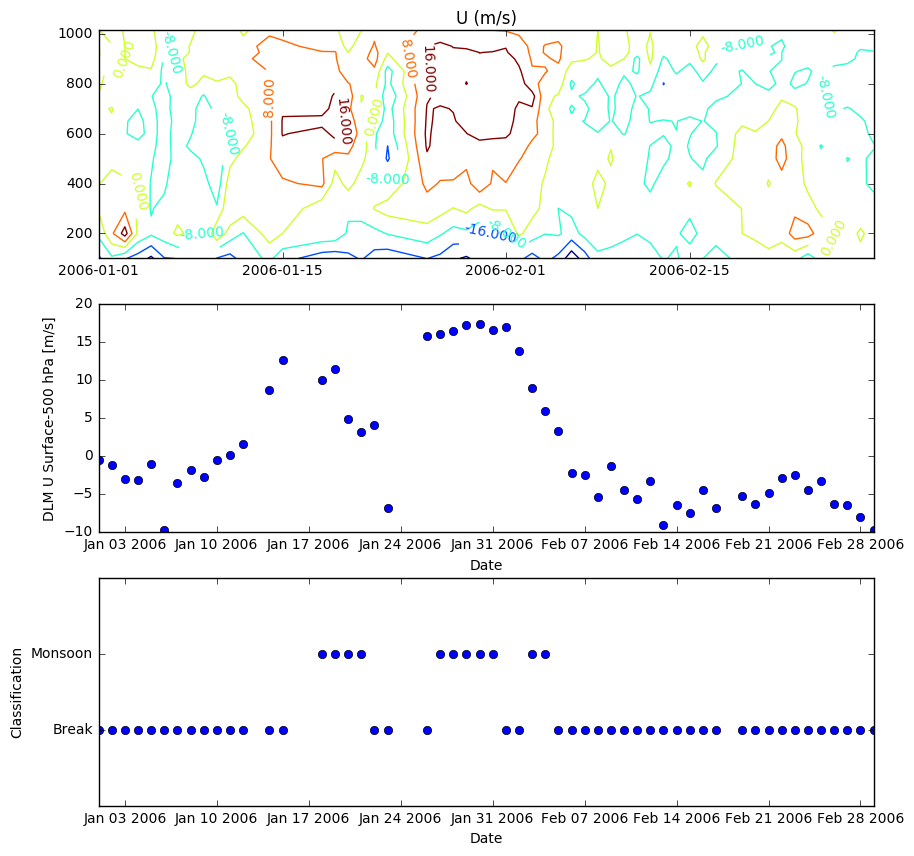

In [9]:
# Input start and end times
start_year = 2006
start_month = 1
start_day = 1

start_time = datetime(year=start_year, 
                      month=start_month, 
                      day=start_day)
end_year = 2006
end_month = 3
end_day = 1

end_time = datetime(year=end_year, 
                    month=end_month, 
                    day=end_day)

indicies = []
datenums = []
i = 0
for times in time_soundings:
    if(times >= start_time and times <= end_time):
        indicies.append(i)
        datenums.append(dates.date2num(times))
                        
    i = i + 1
    
datelocs = [datetime.strptime('2006-01-01', "%Y-%m-%d"),
            datetime.strptime('2006-01-15', "%Y-%m-%d"),
            datetime.strptime('2006-02-01', "%Y-%m-%d"),
            datetime.strptime('2006-02-15', "%Y-%m-%d")]

x = dates.date2num(datelocs)
plt.figure(figsize=(10,10))
plt.subplot(311)
X,Y = np.meshgrid(pres_levels, datenums)
Z = u_soundings[indicies][:]
CS = plt.contour(Y, X, Z)

plt.clabel(CS, inline=1, fontsize=10)
plt.title('U (m/s)')
plt.gca().set_xticks(x)

# Set the xtick labels to correspond to just the dates you entered.
plt.gca().set_xticklabels([date.strftime("%Y-%m-%d") for date in datelocs])

# Calculate the pressure weighted DLM for each timestep
DLM = np.zeros(len(indicies))
U_300100 = np.zeros(len(indicies))
cape = np.zeros(len(indicies))
shear_u = np.zeros(len(indicies))
j = 0
g = -9.8 * units.meters * (units.seconds * units.seconds)
#x = np.multiply(dz[indicies1], 
#                np.divide((prof[indicies1] - t_mean[indicies1]),
#                (t_mean[indicies1]).to('degK')))

for i in indicies:
    print(sum(pres_levels[0:11]*u_soundings[i,0:11])/(np.sum(pres_levels[0:11])))
    DLM[j] = np.sum(pres_levels[0:11]*u_soundings[i,0:11])/(np.sum(pres_levels[0:11]))
    U_300100[j] = np.mean(u_soundings[i,13:15])
    j = j + 1

classification_Drosdowsky = np.zeros(len(DLM))
j = 0
N = 1
break_spell = 0
U = 2.5
for i in range(0,len(DLM)):
    print(DLM[i])
    if(np.mean(DLM[i-N:i]) > U*(N+1)/N and DLM[i] > 0):
        if(U_300100[i] < 0):
            N = N + 1
        else:
            if(N > 1):
                classification_Drosdowsky[j-N+1:j-1] = 1
                N = 1
    else:
        if(N > 1):
            classification_Drosdowsky[j-N+1:j-1] = 1
            N = 1
    j = j + 1    
    
plt.subplot(312)
plt.plot_date(datenums,DLM)

plt.xlabel('Date')
plt.ylabel('DLM U Surface-500 hPa [m/s]')

plt.subplot(313)
plt.plot_date(datenums,classification_Drosdowsky)
plt.xlabel('Date')
plt.ylabel('Classification')
plt.gca().set_yticks([0,1])
plt.gca().set_yticklabels(['Break', 'Monsoon'])
plt.ylim((-1,2))

## Write classification from 2003 to 2015 to netCDF file

In [54]:
file_path = '/home/rjackson/data/Drosdowsky.cdf'

indicies = []
datenums = []
i = 0
for times in time_soundings:
    indicies.append(i)
    datenums.append(dates.date2num(times)) 
    i = i + 1
    
# Calculate the pressure weighted DLM for each timestep
DLM = np.zeros(len(indicies)-1)
U_300100 = np.zeros(len(indicies)-1)
year = np.zeros(len(indicies)-1)
month = np.zeros(len(indicies)-1)
day = np.zeros(len(indicies)-1)
cape = np.zeros(len(indicies)-1)
shear = np.zeros(len(indicies)-1)
cin = np.zeros(len(indicies)-1)
rh500 = np.zeros(len(indicies)-1)
j = 0
g = 9.8 * units.meters * (units.seconds * units.seconds)
for i in range(0,len(indicies)-1):
    DLM[j] = sum(pres_levels[0:11]*u_soundings[i,0:11]/(sum(pres_levels[0:11])))
    U_300100[j] = np.mean(u_soundings[i,13:15])
    shear[j] = u_soundings[i,11]-u_soundings[i,0]
    year[j] = time_soundings[i].year
    month[j] = time_soundings[i].month
    day[j] = time_soundings[i].day
    pres_levels = pres_soundings[i,:] * units.millibar
    t_mean = t_soundings[i,:] * units.celsius
    dp_mean = dp_soundings[i,:] * units.celsius
    prof = mpcalc.parcel_profile(pres_levels, t_mean[0], dp_mean[0]).to('degK')
    LI = prof-t_mean.to('degK')
    dz = z_soundings[i][:]
    dz[0] = z_soundings[i,0]
    dz[1:] = z_soundings[i,1:]-z_soundings[i,0:-1]
    dz = dz * units.meters
    indicies1 = np.where(LI > 0 * units.kelvin)[0]
    diff_indicies1 = deepcopy(indicies1)
    diff_indicies1[1:] = indicies1[1:]-indicies1[:-1]
    indicies1 = indicies1[np.where(diff_indicies1 < 3)]
    x = np.multiply(dz[indicies1], 
                    np.divide((prof[indicies1] - t_mean[indicies1].to('degK')),
                    (t_mean[indicies1]).to('degK')))
    this = g*np.sum(x)   
    cape[j] = np.array(this)
    indicies1 = np.where(LI < 0 * units.kelvin)[0]
    diff_indicies1 = deepcopy(indicies1)
    diff_indicies1[1:] = indicies1[1:]-indicies1[:-1]
    indicies1 = indicies1[diff_indicies1 < 3]
    x = np.multiply(dz[indicies1], 
                    np.divide((prof[indicies1] - t_mean[indicies1].to('degK')),
                    (t_mean[indicies1]).to('degK')))
    this = g*np.sum(x)    
    cin[j] = np.array(this)
    rh500[j] = rh_soundings[i,11]
    j = j + 1

classification_Drosdowsky = np.zeros(len(DLM))
j = 0
N = 1
break_spell = 0
U = 2.5
# Calculate Deep Layer Mean wind and classify time periods

for i in range(0,len(DLM)-1):
    if(np.mean(DLM[i-N:i]) > U*(N+1)/N and DLM[i] > 0):
        if(U_300100[i] < 0):
            N = N + 1
        else:
            if(N > 1):
                classification_Drosdowsky[j-N+1:j-1] = 1
                N = 1
    else:
        if(N > 1):
            classification_Drosdowsky[j-N+1:j-1] = 1
            N = 1
    j = j + 1

# Output to netCDF file
out_netcdf = Dataset(file_path, mode='w')            
out_netcdf.createDimension('time', len(classification_Drosdowsky))

print(len(classification_Drosdowsky))
groups_file = out_netcdf.createVariable('groups', 'i4', ('time',))
groups_file.long_name = 'Drosdowsky classification regime'
groups_file.units = '0 = Break, 1 = Monsoon'
groups_file[:] = classification_Drosdowsky

years_file = out_netcdf.createVariable('year', year.dtype, ('time',))
years_file.long_name = 'Year'
years_file.units = 'YYYY'
years_file[:] = year

month_file = out_netcdf.createVariable('month',  month.dtype, ('time',))
month_file.long_name = 'Month'
month_file.units = 'MM'
month_file[:] = month

day_file = out_netcdf.createVariable('day', day.dtype, ('time',))
day_file.long_name = 'Day'
day_file.units = 'DD'
day_file[:] = day

cape_file = out_netcdf.createVariable('cape', cape.dtype, ('time',))
cape_file.long_name = 'CAPE'
cape_file.units = 'J K-1 kg-1'
cape_file[:] = cape

shear_file = out_netcdf.createVariable('shear', shear.dtype, ('time',))
shear_file.long_name = 'Surface 500 hPa u shear'
shear_file.units = 'm s-1'
shear_file[:] = shear

rh500_file = out_netcdf.createVariable('rh500', shear.dtype, ('time',))
rh500_file.long_name = '500 RH'
rh500_file.units = 'percent'
rh500_file[:] = rh500

out_netcdf.close()

1819


/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Frequency of Monsoon/Break days in Darwin from Nov to May

In [8]:
file_path = '/home/rjackson/data/Drosdowsky.cdf'

in_netcdf = Dataset(file_path)
year = in_netcdf.variables['year'][:]
month = in_netcdf.variables['month'][:]
day = in_netcdf.variables['day'][:]
groups = in_netcdf.variables['groups'][:]
cape = in_netcdf.variables['cape'][:]
shear = in_netcdf.variables['shear'][:]
rh500 = in_netcdf.variables['rh500'][:]

times = []
for i in range(0, len(year)):
    cur_time = datetime(year=int(year[i]),
                        month=int(month[i]),
                        day=int(day[i]))
    times.append(cur_time)

Nov2005 = datetime(2005,11,1,0,0,1)
May2006 = datetime(2006,5,1,0,0,1)
Nov2006 = datetime(2006,11,1,0,0,1)
May2007 = datetime(2007,5,1,0,0,1)
Nov2009 = datetime(2009,11,1,0,0,1)
May2010 = datetime(2010,5,1,0,0,1)
Nov2010 = datetime(2010,11,1,0,0,1)
May2011 = datetime(2011,5,1,0,0,1)

times = np.array(times)
months = np.array([timer.month for timer in times])
time_indicies0506 = np.logical_and(times >= Nov2005,
                                   times <= May2006)
time_indicies0607 = np.logical_and(times >= Nov2006,
                                   times <= May2007)
time_indicies0910 = np.logical_and(times >= Nov2009,
                                   times <= May2010)
time_indicies1011 = np.logical_and(times >= Nov2010,
                                   times <= May2011)
times_summer = np.logical_or(months < 5, months > 10)

#include = np.logical_or(time_indicies0506, time_indicies0607)
#include = np.logical_or(include, time_indicies0910)
#include = np.logical_or(include, time_indicies1011)
include = np.where(times_summer)
year = year[include]
month = month[include]
day = day[include]
groups = groups[include]
cape = cape[include]
shear = shear[include]
rh500 = rh500[include]

2.0
221.0


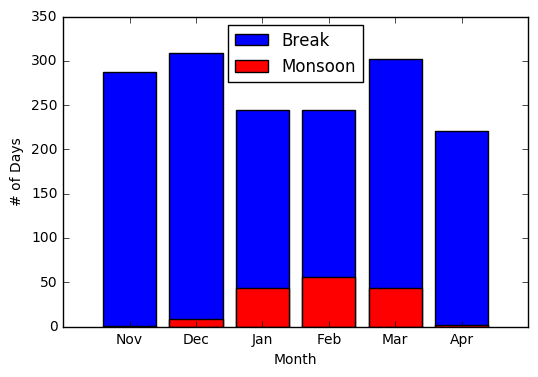

In [9]:
month_bins = [11, 12, 1, 2, 3, 4]
num_monsoon = np.zeros(len(month_bins))
num_break = np.zeros(len(month_bins))

for i in range(0,len(month_bins)):
    inds = np.where(np.logical_and(month == month_bins[i], groups == 1))
    num_monsoon[i] = len(inds[0])
    inds = np.where(np.logical_and(month == month_bins[i], groups == 0))
    num_break[i] = len(inds[0])

mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)
ax.bar(np.arange(0.6,6.6,1), num_break)
ax.bar(np.arange(0.6,6.6,1), num_monsoon, color='r')
ax.set_xticklabels(['','Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr'])
ax.set_xlabel('Month')
ax.set_ylabel('# of Days')
ax.legend(['Break', 'Monsoon'], loc='best')
print(num_monsoon[i])
print(num_break[i])

In [10]:
import pandas
mjo_index_file = '/home/rjackson/data/rmm.74toRealtime.txt'
data = pandas.read_csv(mjo_index_file,
                       header=2,
                       delim_whitespace=True)
data_matrix = np.ma.array(data.values)
year_m = data_matrix[:,0]
month_m = data_matrix[:,1]
day_m = data_matrix[:,2]

mjo = data_matrix[:,5]
amplitude = data_matrix[:,6]
mjo[mjo > 99].mask = True
amplitude[amplitude > 99].mask = True
times = []
for i in range(0, len(year)):
    cur_time = datetime(year=int(year_m[i]),
                        month=int(month_m[i]),
                        day=int(day_m[i]))
    times.append(cur_time)

Nov2005 = datetime(2005,11,1,0,0,1)
May2006 = datetime(2006,5,1,0,0,1)
Nov2006 = datetime(2006,11,1,0,0,1)
May2007 = datetime(2007,5,1,0,0,1)
Nov2009 = datetime(2009,11,1,0,0,1)
May2010 = datetime(2010,5,1,0,0,1)
Nov2010 = datetime(2010,11,1,0,0,1)
May2011 = datetime(2011,5,1,0,0,1)

times = np.array(times)
months = np.array([x.month for x in times])
time_indicies0506 = np.logical_and(times >= Nov2005,
                                   times <= May2006)
time_indicies0607 = np.logical_and(times >= Nov2006,
                                   times <= May2007)
time_indicies0910 = np.logical_and(times >= Nov2009,
                                   times <= May2010)
time_indicies1011 = np.logical_and(times >= Nov2010,
                                   times <= May2011)
print(year_m.shape)
print(include[0].shape)
year_m = year_m[include]
month_m = month_m[include]
day_m = day_m[include]
mjo = mjo[include]
amplitude = amplitude[include]

(15633,)
(1763,)


[  0 186 175 150 151 221 141 153 175]
63
54


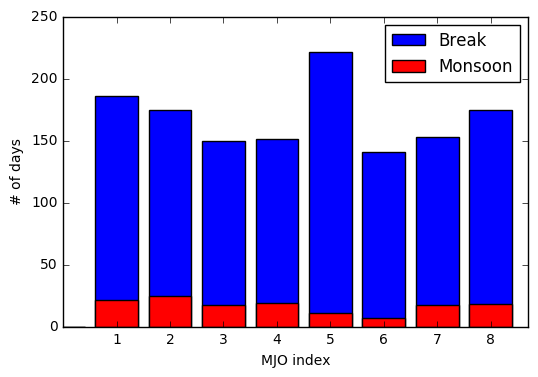

In [14]:
bins = range(0,10)
mjo_hist_break, bins_break = np.histogram(mjo[groups == 0], bins=bins)
mjo_hist_monsoon, bins_monsoon = np.histogram(mjo[groups == 1], bins=bins)

plt.bar(bins_break[:-1]-0.4, mjo_hist_break, color='b')
plt.bar(bins_break[:-1]-0.4, mjo_hist_monsoon, color='r')
plt.gca().set_xticks([1,2,3,4,5,6,7,8])
plt.xlim([0, 8.7])
plt.xlabel('MJO index')
plt.ylabel('# of days')
plt.legend(['Break', 'Monsoon'], loc='best')
print(mjo_hist_break)
print(sum(mjo_hist_monsoon[[0,1,2,7]]))
print(sum(mjo_hist_monsoon[3:7]))

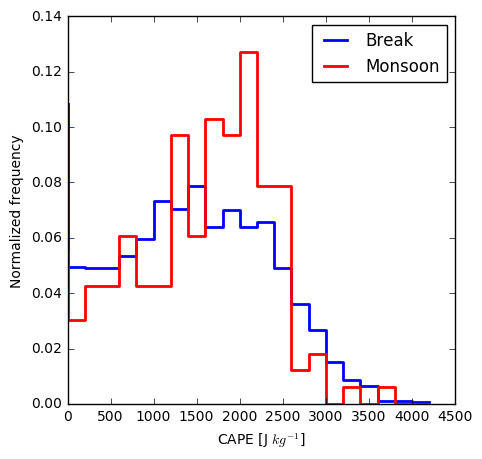

In [24]:
bins = range(0, 4500, 200)
cin_bins = range(-200, 0, 5)
cape[cape < 0] = 0

cape_hist_break, bins_break = np.histogram(cape[groups == 0],
                                           bins=bins,
                                           normed=True)
cape_hist_monsoon, bins_monsoon = np.histogram(cape[groups == 1],
                                               bins=bins,
                                               normed=True)
plt.figure(figsize=(5,5))
plt.step(bins_break[:-1], cape_hist_break*200, color='b', linewidth=2)
plt.step(bins_monsoon[:-1], cape_hist_monsoon*200, color='r', linewidth=2)
plt.ylabel('Normalized frequency')
plt.legend(['Break', 'Monsoon'])
plt.xlabel('CAPE [J $kg^{-1}$]')

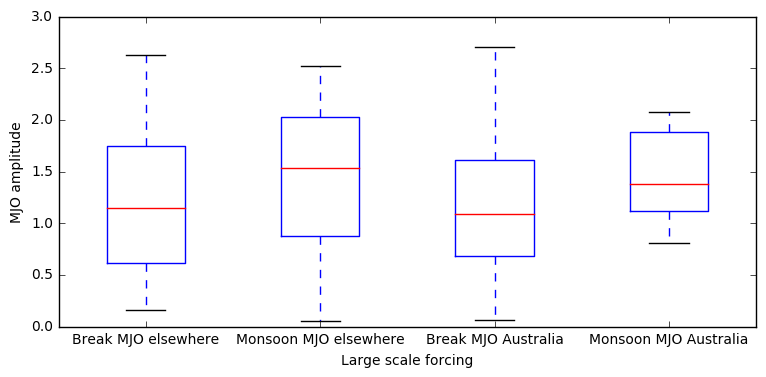

In [66]:
bins = np.arange(0,5,0.5)
amp_b47 = amplitude[np.where(np.logical_and(groups == 0, np.logical_and(mjo >= 4, mjo<=7)))]
amp_m47 = amplitude[np.where(np.logical_and(groups == 1, np.logical_and(mjo >= 4, mjo<=7)))]
amp_b13 = amplitude[np.where(np.logical_and(groups == 0, np.logical_or(mjo == 8, mjo<=3)))]
amp_m13 = amplitude[np.where(np.logical_and(groups == 1, np.logical_or(mjo == 8, mjo<=3)))]
fig = plt.figure(figsize=(9,4,))
ax = fig.add_subplot(111)
plt.boxplot([list(amp_b47), list(amp_m47), list(amp_b13), list(amp_m13)])
plt.xlabel('Large scale forcing')
plt.ylabel('MJO amplitude')
ax.set_xticklabels(['Break MJO elsewhere', 'Monsoon MJO elsewhere', 'Break MJO Australia', 'Monsoon MJO Australia'])

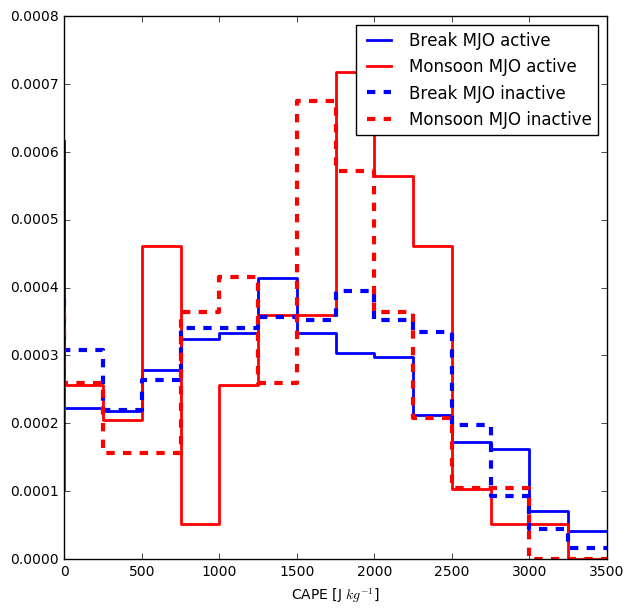

In [14]:
bins = range(0, 4000, 250)
cin_bins = range(-200, 0, 5)
cape[cape < 0] = 0

break_14 = np.where(np.logical_and(groups == 0,
                                   np.logical_or(mjo == 8,
                                                  mjo <= 3)))
break_58 = np.where(np.logical_and(groups == 0,
                                   np.logical_and(mjo >= 4,
                                                  mjo <= 7)))
monsoon_14 = np.where(np.logical_and(groups == 1,
                                     np.logical_or(mjo == 8,
                                                  mjo <= 3)))
monsoon_58 = np.where(np.logical_and(groups == 1,
                                     np.logical_and(mjo >= 4,
                                                   mjo <= 7)))
                                        
cape_hist_break14, bins_break14 = np.histogram(cape[break_14],
                                               bins=bins,
                                               normed=True)
cape_hist_monsoon14, bins_monsoon14 = np.histogram(cape[monsoon_14],
                                                   bins=bins,
                                                   normed=True)
cape_hist_break58, bins_break58 = np.histogram(cape[break_58],
                                               bins=bins,
                                               normed=True)
cape_hist_monsoon58, bins_monsoon58 = np.histogram(cape[monsoon_58],
                                                   bins=bins,
                                                   normed=True)
                      
plt.figure(figsize=(7,7))

plt.step(bins_break14[:-1], 
         cape_hist_break14, 
         color='b', 
         linewidth=2)
plt.step(bins_monsoon14[:-1], 
         cape_hist_monsoon14, 
         color='r', 
         linewidth=2)
plt.step(bins_break58[:-1], 
         cape_hist_break58, 
         color='b', 
         linewidth=3,
         linestyle='--',
         )
plt.step(bins_monsoon58[:-1], 
         cape_hist_monsoon58, 
         color='r', 
         linewidth=3,
         linestyle='--'
         )

plt.legend(['Break MJO active', 'Monsoon MJO active', 'Break MJO inactive', 'Monsoon MJO inactive'])
plt.xlabel('CAPE [J $kg^{-1}$]')

0.478787878788


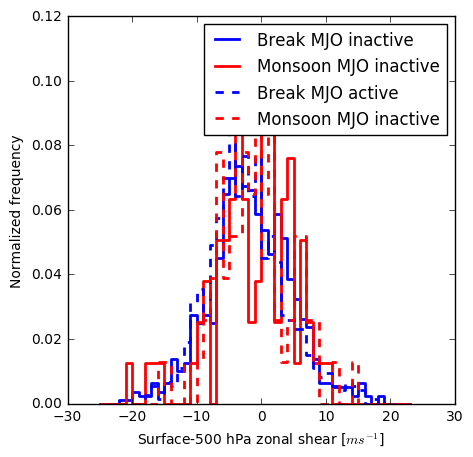

In [19]:
bins = range(-25, 25, 1)
cin_bins = range(-200, 0, 5)
cape[cape < 0] = 0
#cin[cin > 0] = 0
shear_hist_break14, bins_break14 = np.histogram(shear[break_14],
                                               bins=bins,
                                               normed=True)
shear_hist_monsoon14, bins_monsoon14 = np.histogram(shear[monsoon_14],
                                                   bins=bins,
                                                   normed=True)
shear_hist_break58, bins_break58 = np.histogram(shear[break_58],
                                               bins=bins,
                                               normed=True)
shear_hist_monsoon58, bins_monsoon58 = np.histogram(shear[monsoon_58],
                                                   bins=bins,
                                                   normed=True)
plt.figure(figsize=(5,5))
plt.step(bins_break[:-1], shear_hist_break14, color='b', linewidth=2)
plt.step(bins_monsoon[:-1], shear_hist_monsoon14, color='r', linewidth=2)
plt.step(bins_break[:-1], shear_hist_break58, color='b', linestyle='--', linewidth=2)
plt.step(bins_monsoon[:-1], shear_hist_monsoon58, color='r', linestyle='--', linewidth=2)
plt.legend(['Break MJO inactive', 'Monsoon MJO inactive', 'Break MJO active', 'Monsoon MJO inactive'])
plt.xlabel('Surface-500 hPa zonal shear [$m s^{-1}$] ')
plt.ylabel('Normalized frequency')
plt.xlim([-30,30])
print(np.sum(shear_hist_monsoon[1:25]))

0.128571428571


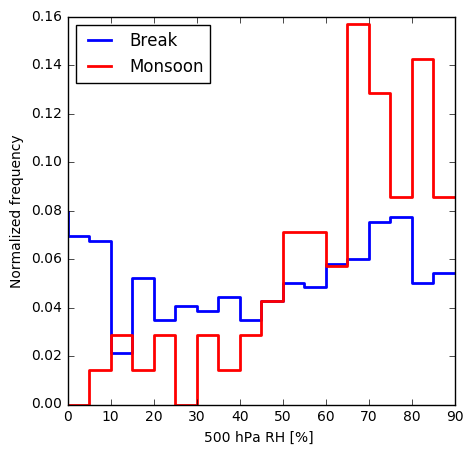

In [61]:
bins = range(0, 100, 5)
cin_bins = range(-200, 0, 5)
cape[cape < 0] = 0
cin[cin > 0] = 0
rh_hist_break, bins_break = np.histogram(rh500[groups == 0],
                                         bins=bins,
                                         normed=True)
rh_hist_monsoon, bins_monsoon = np.histogram(rh500[groups == 1],
                                             bins=bins,
                                             normed=True)
plt.figure(figsize=(5,5))

plt.step(bins_break[:-1], rh_hist_break*5, color='b', linewidth=2)
plt.step(bins_monsoon[:-1], rh_hist_monsoon*5, color='r', linewidth=2)
plt.legend(['Break', 'Monsoon'], loc='best')
plt.xlabel('500 hPa RH [%] ')
plt.ylabel('Normalized frequency')
plt.xlim([0,90])
print(np.sum(rh_hist_monsoon[:9]*5))